### CAM
CAM(Class Activation Map)은 설명 가능한 AI 기술 중 하나다. 이미지 내에서 어느 부분이 모델의 의사결정에 큰 영향을 미쳤는지를 시각화하는 기술이다.


Reference: "Learning Deep Features or Discriminative Localization" by B.Zhou et al.,2015"

### 1. 라이브러리 호출 및 구글드라이브 연동

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Pytorch/pytorch

/content/drive/MyDrive/Pytorch/pytorch
/content/drive/MyDrive/Pytorch/pytorch


### 2. 데이터 및 모델 생성

In [6]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data',split='train',download=True,transform=transform) #96x96
trainloader = torch.utils.data.DataLoader(trainset,batch_size=40,shuffle=True)

#10 classes: ariplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

Files already downloaded and verified


In [8]:
#iter, next를 이용해 일부 데이터를 확인할 수 있다.
dataiter = iter(trainloader)
images,labels = next(dataiter)
print(images.size())

torch.Size([40, 3, 128, 128])


In [9]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features #fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs,10) #fc를 nn.Linear(num_ftrs,10)로 대체한다.
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


### 3. 모델 학습

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4,weight_decay =1e-2)

In [11]:
for epoch in range(20):
  running_loss = 0.0
  for data in trainloader:
    inputs,labels=data[0].to(device),data[1].to(device)

    optimizer.zero_grad()
    outputs=model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()

  cost = running_loss/ len(trainloader)
  print('[%d] loss: %.3f' %(epoch+1,cost))
torch.save(model.state_dict(), './models/stl10_resnet18.pth')
print('Finished Training')

[1] loss: 0.563
[2] loss: 0.109
[3] loss: 0.034
[4] loss: 0.040
[5] loss: 0.102
[6] loss: 0.120
[7] loss: 0.075
[8] loss: 0.058
[9] loss: 0.047
[10] loss: 0.056
[11] loss: 0.077
[12] loss: 0.070
[13] loss: 0.078
[14] loss: 0.049
[15] loss: 0.040
[16] loss: 0.079
[17] loss: 0.066
[18] loss: 0.069
[19] loss: 0.054
[20] loss: 0.069
Finished Training


In [12]:
#Visualize feature maps
activation = {}
def get_activation(name):
  def hook(model,input,output):
    activation[name] = output.detach()
  return hook

In [13]:
def cam(model, trainset, img_sample, img_size):
    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final'))
        # feature extraction의 마지막 feature map 구하기 (layer4[1])

        data, label = trainset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]

        output = model(data.to(device))
        _, prediction = torch.max(output, 1)

        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기

        for idx in range(act.size(0)): # CAM 연산 (결국 for loop으로 모든 가중치 합하는 것!!)
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] # 각 label에 해당하는 가중치
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size))

    return cam_img, original_img

In [14]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20 # 결과 20장 나오게
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img = cam(model, trainset, i, img_size) # cam 이미지 나오는 부분 (오리지널 이미지 , CAM 이미지)

        axs[i - start].imshow(original_img, cmap='gray') # 오리지널은 gray
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.5) # 빨파, alpha는 밝기
        axs[i - start].axis('off')

    plt.show()
    fig.savefig('cam.png')

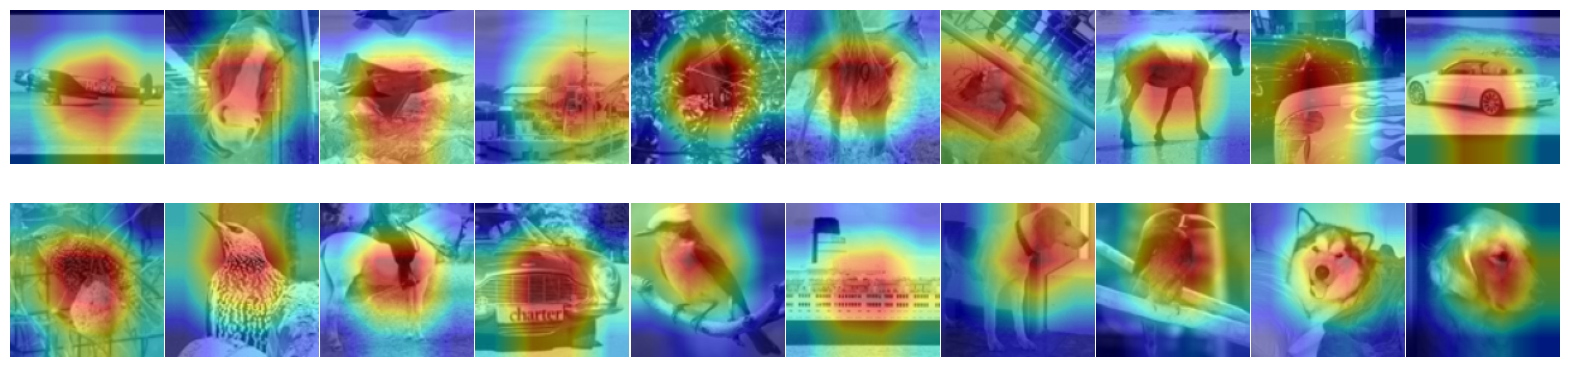

In [15]:
plot_cam(model, trainset, 128, 10)